In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/amazon-alexa-reviews/amazon_alexa.tsv


In [2]:
#importing the required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
from wordcloud import WordCloud
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem.porter import PorterStemmer
STOPWORDS= set(stopwords.words('english'))
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
#load the dataset
df = pd.read_csv('/kaggle/input/amazon-alexa-reviews/amazon_alexa.tsv', sep='\t')
df.head()

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1
4,5,31-Jul-18,Charcoal Fabric,Music,1


**Exploratory Data Analysis**

In [10]:
df.shape

(3150, 5)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3150 entries, 0 to 3149
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   rating            3150 non-null   int64 
 1   date              3150 non-null   object
 2   variation         3150 non-null   object
 3   verified_reviews  3149 non-null   object
 4   feedback          3150 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 123.2+ KB


In [6]:
#check for null values
df.isna().sum()

rating              0
date                0
variation           0
verified_reviews    1
feedback            0
dtype: int64

In [9]:
#check the null row
df[df['verified_reviews'].isna()]

,rating,date,variation,verified_reviews,feedback
473,2,29-Jun-18,White,NaN,0


In [13]:
#drop the missing value row
df.dropna(inplace=True)
df.shape

(3149, 5)

In [14]:
#create a new column 'length' for length of the reviews
df['length'] = df['verified_reviews'].apply(len)
df.head()

,rating,date,variation,verified_reviews,feedback,length
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1,13
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1,9
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1,195
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1,172
4,5,31-Jul-18,Charcoal Fabric,Music,1,5


Analysing the 'rating' column

In [15]:
df['rating'].value_counts()

rating
5    2286
4     455
1     161
3     152
2      95
Name: count, dtype: int64

<Axes: xlabel='rating', ylabel='count'>

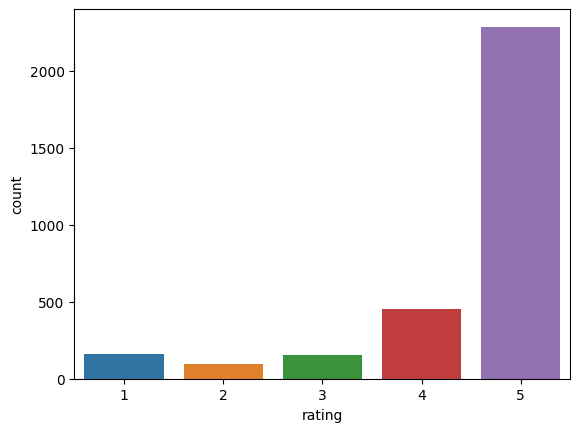

In [17]:
#plotting the counts of 'rating' values
sns.countplot(x='rating', data=df)

In [18]:
#percentage distribution
df['rating'].value_counts(normalize=True)

rating
5    0.725945
4    0.144490
1    0.051127
3    0.048269
2    0.030168
Name: proportion, dtype: float64

<Axes: ylabel='proportion'>

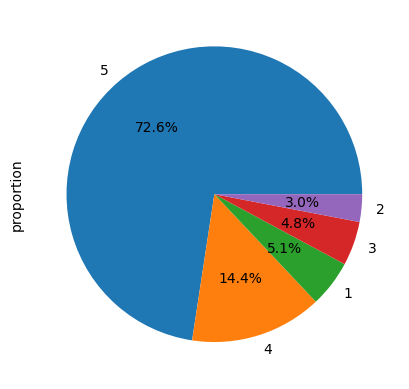

In [21]:
df['rating'].value_counts(normalize=True).plot(kind='pie', autopct="%1.1f%%")

Analysing feedback column

In [22]:
df['feedback'].value_counts()

feedback
1    2893
0     256
Name: count, dtype: int64

<Axes: xlabel='feedback', ylabel='count'>

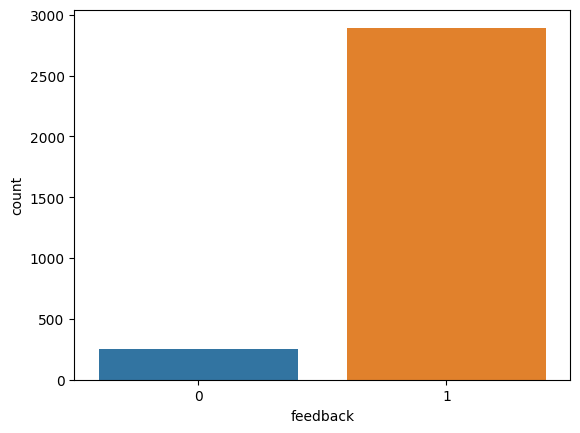

In [23]:
#plotting
sns.countplot(x='feedback', data=df)

In [24]:
#percentage distribution
df['feedback'].value_counts(normalize=True)

feedback
1    0.918704
0    0.081296
Name: proportion, dtype: float64

<Axes: ylabel='proportion'>

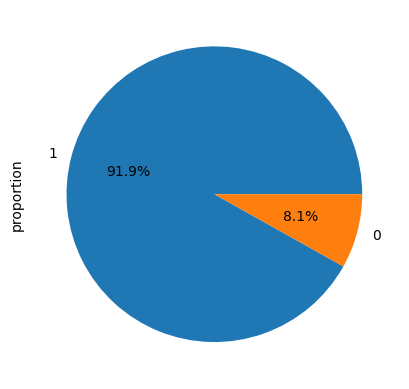

In [25]:
df['feedback'].value_counts(normalize=True).plot(kind='pie', autopct="%1.1f%%")

In [27]:
#understanding feedback based on the rating
df.groupby('feedback')['rating'].value_counts()

feedback  rating
0         1          161
          2           95
1         5         2286
          4          455
          3          152
Name: count, dtype: int64

implies that:
1 and 2 rating indicates negative review &
3, 4 and 5 indicated a positive review.

Analysing the 'varitation' column

In [28]:
df['variation'].value_counts()

variation
Black  Dot                      516
Charcoal Fabric                 430
Configuration: Fire TV Stick    350
Black  Plus                     270
Black  Show                     265
Black                           261
Black  Spot                     241
White  Dot                      184
Heather Gray Fabric             157
White  Spot                     109
Sandstone Fabric                 90
White                            90
White  Show                      85
White  Plus                      78
Oak Finish                       14
Walnut Finish                     9
Name: count, dtype: int64

<Axes: xlabel='variation'>

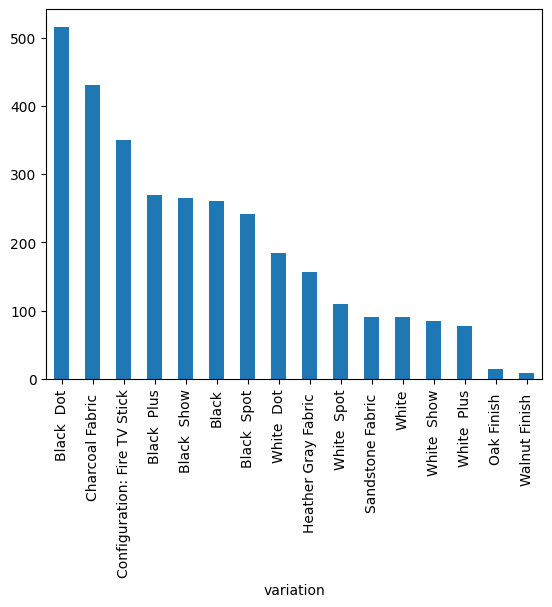

In [31]:
df['variation'].value_counts().plot(kind='bar')

In [32]:
#percentage distribution
df['variation'].value_counts(normalize=True)

variation
Black  Dot                      0.163862
Charcoal Fabric                 0.136551
Configuration: Fire TV Stick    0.111146
Black  Plus                     0.085742
Black  Show                     0.084154
Black                           0.082883
Black  Spot                     0.076532
White  Dot                      0.058431
Heather Gray Fabric             0.049857
White  Spot                     0.034614
Sandstone Fabric                0.028581
White                           0.028581
White  Show                     0.026993
White  Plus                     0.024770
Oak Finish                      0.004446
Walnut Finish                   0.002858
Name: proportion, dtype: float64

<Axes: ylabel='proportion'>

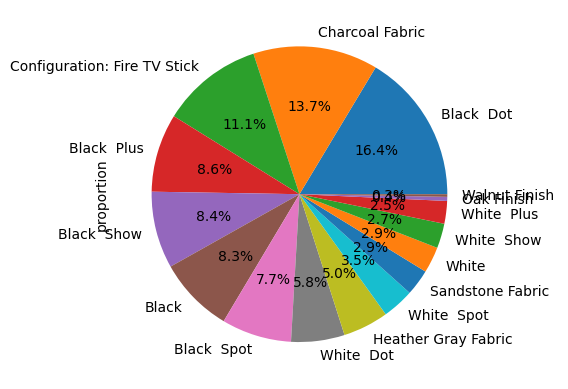

In [33]:
df['variation'].value_counts(normalize=True).plot(kind='pie', autopct='%1.1f%%')

Relation between variation and rating,feedback & length

In [50]:
df.groupby('variation')[['rating','feedback','length']].mean().sort_values(by='rating' ,ascending=False)

,rating,feedback,length
variation,,,
Walnut Finish,4.888889,1.000000,137.666667
Oak Finish,4.857143,1.000000,103.714286
Charcoal Fabric,4.730233,0.972093,119.118605
Heather Gray Fabric,4.694268,0.987261,117.197452
Configuration: Fire TV Stick,4.591429,0.920000,86.542857
Black Show,4.490566,0.932075,146.203774
Black Dot,4.453488,0.930233,113.920543
White Dot,4.423913,0.934783,94.913043
Black Plus,4.370370,0.896296,185.796296


<Axes: xlabel='variation'>

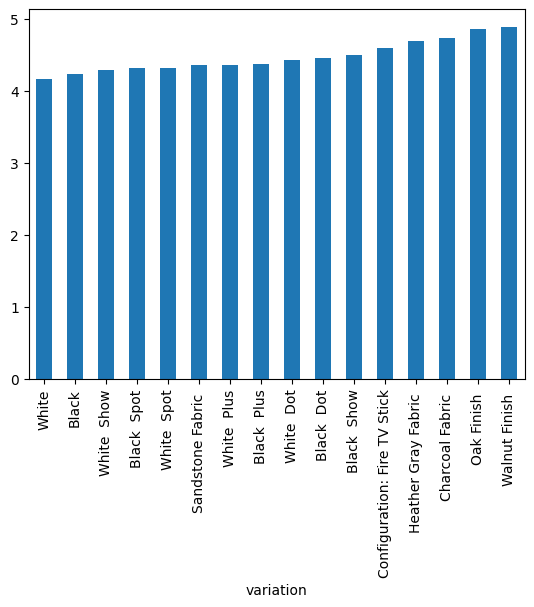

In [54]:
#variation vs rating
df.groupby('variation')['rating'].mean().sort_values().plot(kind='bar')

Analysing 'length' column

In [55]:
df['length'].describe()

count    3149.000000
mean      132.090187
std       182.114569
min         1.000000
25%        30.000000
50%        74.000000
75%       165.000000
max      2851.000000
Name: length, dtype: float64

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='length', ylabel='Count'>

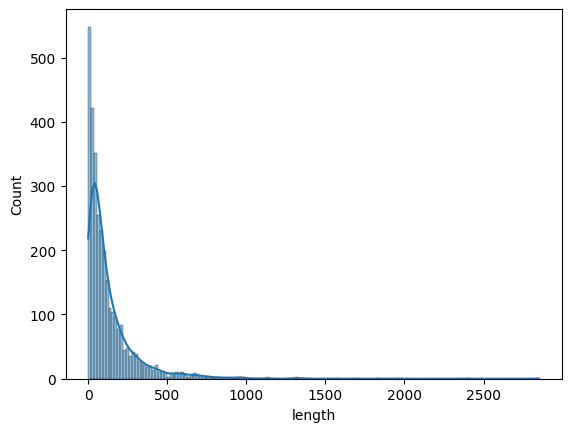

In [57]:
#distribution of lengths
sns.histplot(data=df, x='length', kde=True)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='length', ylabel='Count'>

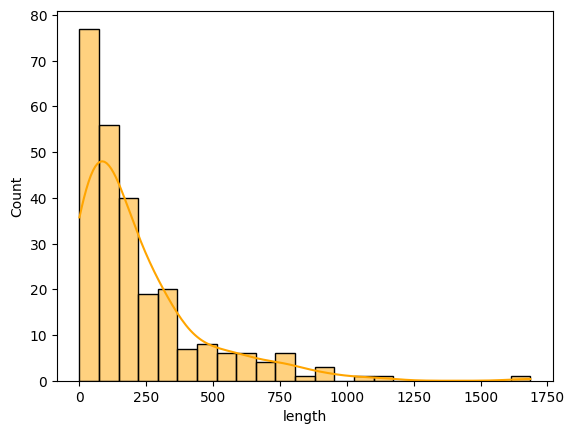

In [62]:
#'length' analysis for '0' feedback
sns.histplot(df[df['feedback']==0]['length'], kde=True, color='orange')

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='length', ylabel='Count'>

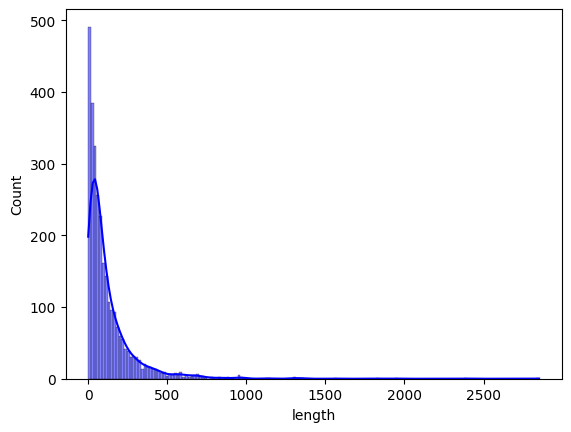

In [63]:
#'length' analysis for '1' feedback
sns.histplot(df[df['feedback']==1]['length'], kde=True, color='blue')

'verified_reviews' analysis

In [66]:
cv = CountVectorizer(stop_words='english')
words = cv.fit_transform(df['verified_reviews'])

In [71]:
review_string = " ".join(df['verified_reviews'])

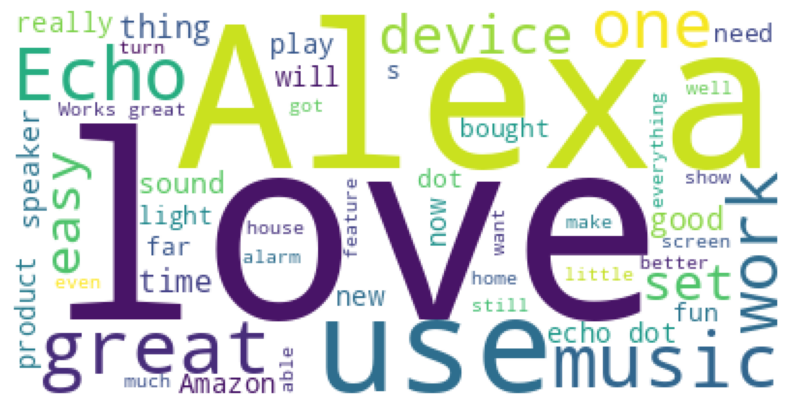

In [75]:
wc = WordCloud(background_color='white', max_words=50)
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(review_string))
plt.axis('off')
plt.show()

Separating negative and positive reviews

In [76]:
positive_review = " ".join(df[df['feedback']==1]['verified_reviews'])
negative_review = " ".join(df[df['feedback']==0]['verified_reviews'])

#split the string into list of words
neg_reviews= negative_review.lower().split()
pos_reviews= positive_review.lower().split()

In [78]:
#finding unique words in positive and negative reviews
un_neg = [x for x in neg_reviews if x not in pos_reviews]
un_neg = " ".join(un_neg)

un_pos = [x for x in pos_reviews if x not in neg_reviews]
un_pos = " ".join(un_pos)

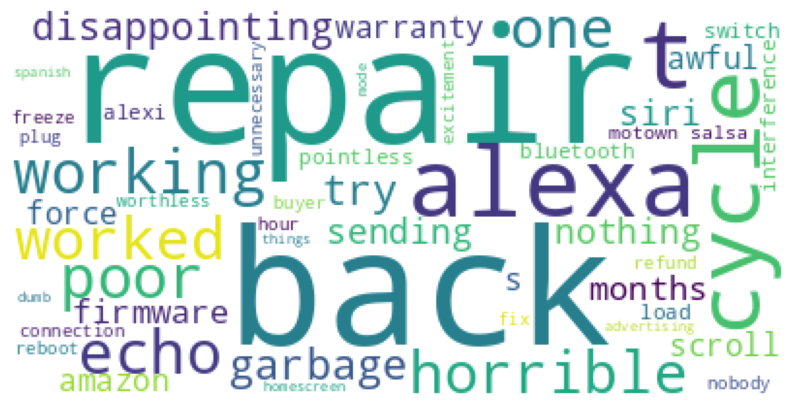

In [83]:
#word cloud of negative reviews
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(un_neg))
plt.axis('off')
plt.show()

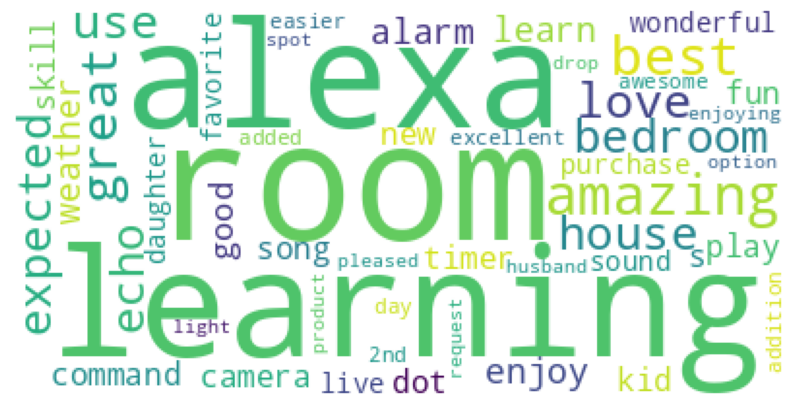

In [84]:
#word cloud of positive reviews
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(un_pos))
plt.axis('off')
plt.show()

**Data Preprocessing and Modelling**

In [88]:
#building corpus
corpus = []

stemmer = PorterStemmer()
for i in range(0, df.shape[0]):
    review = re.sub('[^a-zA-Z]',' ', df.iloc[i]['verified_reviews'])
    review = review.lower().split()
    review = [stemmer.stem(word) for word in review if word not in STOPWORDS]
    review = ' '.join(review)
    corpus.append(review)

In [94]:
cv = CountVectorizer(max_features=2500)
X = cv.fit_transform(corpus).toarray()
y = df['feedback'].values

In [99]:
#saving the cv
import pickle
pickle.dump(cv, open('cv.pkl', 'wb'))

In [101]:
#shape of x and y
print(f"x shape: {x.shape}")
print(f"y shape: {y.shape}")

x shape: (3149, 2500)
y shape: (3149,)


In [102]:
#splitting the data into train and test
x_train, x_test, y_train, y_test= train_test_split(x, y, test_size= 0.2, random_state= 0)

In [107]:
from sklearn.preprocessing import StandardScaler

# Initialize StandardScaler
scaler = StandardScaler()

# Fit on training data and transform it
x_train_sc = scaler.fit_transform(x_train)

# Transform test data (using the same scaler as fitted on training data)
x_test_sc = scaler.transform(x_test)


In [108]:
#saving the scalar model
pickle.dump(scaler, open('scaler.pkl', 'wb'))

Random forest classifier

In [109]:
rfc= RandomForestClassifier()
rfc.fit(x_train_sc, y_train)

RandomForestClassifier()

In [110]:
#accuracy of the model
print("training accuracy: ", rfc.score(x_train_sc, y_train))
print("testing accuracy: ", rfc.score(x_test_sc, y_test))

training accuracy:  0.9924573243350536
testing accuracy:  0.9476190476190476


In [111]:
#predicting the results
pred1= rfc.predict(x_test_sc)
pred1

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [112]:
cm= confusion_matrix(y_test, pred1)
cm

array([[ 14,  31],
       [  2, 583]])

XGBoost

In [113]:
xgb= XGBClassifier()
xgb.fit(x_train_sc, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [114]:
#accuracy of the model
print(f"training accuracy: {xgb.score(x_train_sc, y_train)}")
print(f"testing accuracy: {xgb.score(x_test_sc, y_test)}")

training accuracy: 0.9753870583564906
testing accuracy: 0.9365079365079365


In [115]:
#predictions
pred2= xgb.predict(x_test)
pred2

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [116]:
cm= confusion_matrix(y_test, pred2)
cm

array([[  0,  45],
       [  1, 584]])

Decision Tree

In [117]:
dt= DecisionTreeClassifier()
dt.fit(x_train_sc, y_train)

DecisionTreeClassifier()

In [118]:
#accuracy of the model
print(f"training accuracy: {dt.score(x_train_sc, y_train)}")
print(f"testing accuracy: {dt.score(x_test_sc, y_test)}")

training accuracy: 0.9928543072647876
testing accuracy: 0.9285714285714286


In [119]:
pred3= dt.predict(x_test)
cm= confusion_matrix(y_test, pred3)
cm

array([[  0,  45],
       [  1, 584]])